## Task 1: Explore the dataset!
   - Gather information about the dataset we have
   - Bonus points for observations about how they'll affect training, how to mitigate possible issues



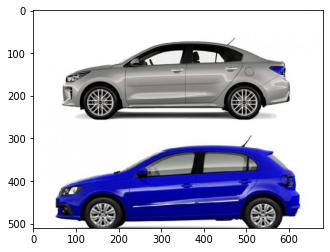

In [3]:
# %%
import random
import os
import string
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

os.listdir('../../data/mini-coco')

img = cv2.imread('../../data/mini-coco/sedan/001956_I_5122630_1_190626_170302_105_0561.jpg.jpg')
plt.imshow(img)

In [21]:
#Proposed solution
"""
Idea: Because of the Folder-based nature of the dataset, walk through the directories and get the image names
then use the image names to get stats about the extensions, image heights and widths, also calculate the mean and std
because it'll useful during the training phase of the Object Detector 
additionally, make sure that the images are not corrupted by trying to read it with OpenCV
conform a Pandas DataFrame with this info and show it on graphs
"""
dataset_dir = "../../data/mini-coco" 
image_classes = os.listdir('../../data/mini-coco') #Get image classes
print(f"Classes in this Folder-based dataset: {image_classes} Number of clases: {len(image_classes)} ")
dataset_info = []
for img_class in image_classes:
    class_files = os.listdir(os.path.join(dataset_dir, img_class))
    for file in class_files:
        filepath = os.path.join(dataset_dir, img_class, file)
        extension = file.split(".")[-1]
        img_width = img_height = img_channels = std = mean = None #Initialize files
        try:
            img = cv2.imread(filepath)
            img_height, img_width, img_channels = img.shape
            mean, std = cv2.meanStdDev(img) #Calculate mean and std 
            mean = mean.squeeze()
            std = std.squeeze()
        except:
            pass #Just show img info as None and check it in Pandas
        dataset_element = {"filepath": filepath, "extension": extension, "class": img_class,
                           "img_width": img_width, "img_height": img_height, 
                          "img_channels": img_channels, "std": std, "mean": mean}
        dataset_info.append(dataset_element)
df_dataset = pd.DataFrame(dataset_info)

Classes in this Folder-based dataset: ['sedan', 'truck', 'van', 'bus', 'suv'] Number of clases: 5 


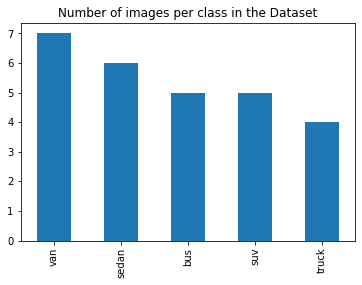

In [22]:
# Show the number of images per class
_ = df_dataset["class"].value_counts().plot.bar(title="Number of images per class in the Dataset")

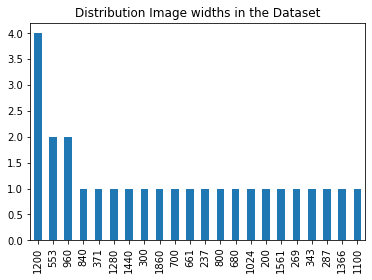

In [8]:
_ = df_dataset["img_width"].value_counts().plot.bar(title="Distribution Image widths in the Dataset")

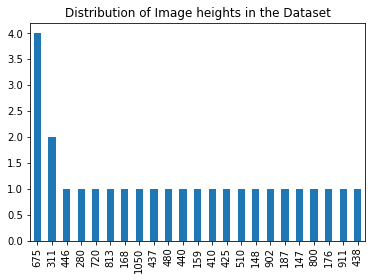

In [9]:
_ = df_dataset["img_height"].value_counts().plot.bar(title="Distribution of Image heights in the Dataset")

In [10]:
_ = df_dataset["extension"].value_counts().plot.bar(title="Image formats found in the dataset")

In [26]:
"""
Calculate the std and mean of the dataset
check if any images has 
"""
dataset_std = df_dataset["std"]
dataset_mean = df_dataset["mean"]
number_elements = len(dataset_mean)
dataset_average_std = []
dataset_average_mean = []
for idx in range(number_elements):
    if idx == 0:
        dataset_average_mean = dataset_mean.iloc[idx]
        dataset_average_std = dataset_std.iloc[idx]
    else:
        dataset_average_mean = np.add(dataset_average_mean, dataset_mean.iloc[idx])
        dataset_average_std = np.add(dataset_average_std, dataset_std.iloc[idx]) 
dataset_average_mean /= number_elements
dataset_average_std /= number_elements
print(f"Mean of the Dataset: {dataset_average_mean}, \nStandard Deviation of the Dataset: {dataset_average_std} ", )
df_none = df_dataset[df_dataset["img_width"] == None]
if df_none["extension"].any():
    print(f"There are {df_none.value_counts().values} images that couldn't be loaded by OpenCV or are corrupted"  )
else:
    print("All the images are correct!")

Mean of the Dataset: [144.86706726 142.91583525 147.50120968], 
Standard Deviation of the Dataset: [75.80133761 75.94681867 73.08425204] 
All the images are correct!


## Observations about the Dataset
(I've used a small test dataset for this demonstration, so I'd assume this wil be the case of a larger one)
- The classes are unbalanced, so it'll be neccesary to add more samples to the underrepresented ones 
- There's a wide variety of resolutions in the dataset, the most common dimension is: 1200x675 px, to crop the images for the training process the best size might be 256x256 to avoid unnecesary loss of information because of this transformation
- The most common image format is jpg and they are currently supported by the OpenCV `imread` method
- The mean `[144.86706726 142.91583525 147.50120968]` and `[75.80133761 75.94681867 73.08425204]` of the dataset is similar to the ImageNet mean `[123.675 116.28 103.53]` and `[58.395 57.12 57.375]` so it might mean that there're good representation of the objects and probably a low percentage of outliers
- In my dataset, all the images could be loaded and no corrupted files were found

## Task 2: Prepare for training!
- Prepare the dataset for an exploratory training attempt
- Bonus points for observations about usable ConvNet models, evaluation methods, public data sources

In [239]:
# Solution Proposed
#Using Sklearn Library 
from sklearn.model_selection import train_test_split
def split_dataset(all_samples, test_ratio = 0.15, val_ratio = 0.1):
    """
    Attributes
    ----------
    all_samples : list
        total samples of the dataset
    test_ratio : float
        test ratio to split the test dataset of the total dataset
    val_ratio : float
        val_ratio to split the val dataset of the total dataset
    Returns
    ----------
    training : list
        Splitted dataset to the desired training ratio
    testing : list
        Splitted dataset to the desired testing ratio
    validation : list
        Splitted dataset to the desired validation ratio
        
    """
    # Proposed solution
    test_and_val_ratio = test_ratio + val_ratio #First split the data into a test and train dataset 
    training, test_val = train_test_split(all_samples, test_size = test_and_val_ratio, shuffle=True)
    #Calculate the final val ratio for the test_val dataset
    final_val_ratio = val_ratio/test_and_val_ratio
    testing, validation = train_test_split(test_val, test_size = final_val_ratio, shuffle=True) #Split again the remaining dataset to conform the testing and validation dataset
 
    return training, validation, testing

In [ ]:
# %%
# This cell will be used to check your split_dataset() function
all_samples = []
for i in range(100000):
    object_class = random.choice(['van', 'sedan', 'bus', 'truck'])
    box = {'x': random.randint(0, 1000),
           'y': random.randint(0, 1000),
           'w': random.randint(0, 1000),
           'h': random.randint(0, 1000)}
    box = frozenset(box.items())
    lp_alphabet = string.ascii_uppercase + string.digits
    lp_text = ''.join([random.choice(lp_alphabet) for i in range(6)])
    sample = {'img': f'./data/mini-coco/{object_class}/{i}.jpg',
              'class': object_class,
              'box': box,
              'lp_text': lp_text}
    sample = frozenset(sample.items())

    all_samples.append(sample)

training, validation, testing = [set(s) for s in split_dataset(all_samples)]

expected_size = len(all_samples)
actual_size = len(training) + len(validation) + len(testing)
assert actual_size == expected_size, \
    f'Subsets should have {expected_size} samples, actually have {actual_size}'

duplicates = training & validation
duplicates.union(training & testing)
duplicates.union(validation & testing)
assert len(duplicates) == 0, \
    'At least one sample appears in multiple subsets'

## Observations of the prepare for training part
Note 1: I've used the `train_test_split` method from the `sklearn` library 
Note 2: To do not modify the dataset `frozenset` type I just use the variable as it
- It'll be neccesary to perform an analysis to determine how much balanced the dataset is. 
- In case of not being possible to balance the dataset with new samples, it might be useful to use the `sklearn.utils.class_weight.compute_class_weight` library to add this parameter to the loss function
- To ensure representativity, it'll be a good idea, to split first the dataset per class, that subset then is splitted in the adequate proportions and then merged again, with this, the validation and the testing dataset's operations might be more accurated.
- The splitting part was done randomly via the use of the `shuffle` option
- The proportions for the dataset where `[0.75, 0.15, 0.10]` can be configured via the `test_ratio` and `val_ratio` of the method, however it might be more accurated to use the k-fold method for validation
- The metrics that can be used are: COCO Metrics for the detection part and the Region under the Curve for the classification one. 

## Task 3: Convert boxes from absolute to relative coordinates!
- Your function receives the size and position of a box in pixels
- The returned box should be valid even if the frame is resized (with the same aspect ratio)

In [247]:
# Proposed solution
def absolute_to_relative(absolute_box, frame_size):
    """
    Attributes
    ----------
    absolute_box : dict
        Dictionary that contais the top, left, right, height and width of the bbox in integer
    frame_size : dict
        Dictionary that contains the absolute width and height of the frame_size in integer
    Returns
    ----------
    relative_box : dict
        Dict that contains the x, y center coordinates and the relative height and width of the bbox in a float data type
    """
    # TODO: Implement this!
    relative_box = {'x': 0,
                    'y': 0,
                    'height': 0,
                    'width': 0}
    rel_x_center = (absolute_box["left"] + absolute_box["width"]/2) / frame_size["width"]
    relative_box["x"] = rel_x_center
    rel_y_center = (absolute_box["top"] + absolute_box["height"]/2) / frame_size["height"]
    relative_box["y"] = rel_y_center
    rel_bbox_width = absolute_box["width"] / frame_size["width"]
    relative_box["width"] = rel_bbox_width
    rel_bbox_height = absolute_box["height"] / frame_size["height"]
    relative_box["height"] = rel_bbox_height
    
    return relative_box

In [248]:
# %%
# This cell will be used to check your absolute_to_relative() function

frame_size = {'width': 800,
              'height': 600}

absolute_box = {'top': 225,
                'left': 200,
                'height': 150,
                'width': 400}

# The expected result
# Note that the coordinates point to the middle of the box
expected_box = {'x': 0.5,
                'y': 0.5,
                'height': 0.25,
                'width': 0.5}

result_box = absolute_to_relative(absolute_box, frame_size)
assert result_box == expected_box, \
    f'{result_box} != {expected_box}'